# Amortized Inference for a NLME Model

## Individual Fit - Empirical Bayes

In [ ]:
import os
import pickle
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pypesto.optimize as pesto_opt
from pypesto import FD, Objective, Problem, store
from scipy.stats import normaltest
from scipy import stats
from tqdm import tqdm

# for amortized inference  # todo: something with this imports is not working, kills jupyter
from inference.inference_functions import create_boundaries_from_prior
from inference.nlme_objective import get_covariance
from inference.empirical_bayes import ObjectiveFunctionEmpiricalBayes

In [ ]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 
              'pharmacokinetic_model', 
              'clairon_small_model'][-1]

## Load ODE model


In [ ]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple, batch_simulator
    individual_model = FroehlichModelSimple(load_best=True)
    n_data = 500
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed, batch_simulator
    individual_model = FroehlichModelDetailed(load_best=True)
    n_data = 500
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel, simulate_single_patient, convert_bf_to_observables
    individual_model = PharmacokineticModel(load_best=True)    
    n_data = 47
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel, simulate_single_patient, convert_bf_to_observables
    prior_type = ['normal', 'uniform'][0]
    individual_model = ClaironSmallModel(load_best=True, prior_type=prior_type)
    n_data = 742
else:
    raise NotImplementedError('model not implemented')

trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)

In [ ]:
if 'clairon' in model_name:
    obs_data, covariates = individual_model.load_data(n_data=n_data, load_covariates=True)
else:
    obs_data = individual_model.load_data(n_data=n_data)
posterior_draws = individual_model.draw_posterior_samples(data=obs_data, n_samples=100)
print(len(obs_data))

In [ ]:
#obs_data = obs_data[:200]

## Single Cell / Patient

In [ ]:
individual_idx = 0

# simulate
if 'fröhlich' in model_name:
    t_measurements_full = np.linspace(start=1 / 6, stop=30, num=180, endpoint=True)
    y_sim = batch_simulator(posterior_draws[individual_idx], 
                            with_noise=False).squeeze(axis=2)
    t_measurements = t_measurements_full
    y = obs_data[individual_idx]
elif 'clairon' in model_name or 'pharma' in model_name:
    y_sim = simulate_single_patient(posterior_draws[individual_idx], 
                                    patient_data=obs_data[individual_idx], 
                                    full_trajectory=True,
                                    with_noise=False)
    observations = convert_bf_to_observables(obs_data[individual_idx])
    # this is the same for the clairon and pharma model
    y = observations[0]
    t_measurements = observations[1]
    doses_time_points = observations[2]
    t_measurements_full = np.linspace(0, t_measurements[-1], 100)
else:
    raise NotImplemented

In [ ]:
# compute median and 95% percentiles
if 'pharma' in model_name:
    # pharma has two observables
    y_median_1 = np.median(y_sim[:, :, 0], axis=0)
    y_perc_1 = np.percentile(y_sim[:, :, 0], (2.5, 97.5), axis=0)
    y_median_2 = np.median(y_sim[:, :, 1], axis=0)
    y_perc_2 = np.percentile(y_sim[:, :, 1], (2.5, 97.5), axis=0)
    plt.plot(t_measurements_full, y_median_1, color='orange', alpha=0.2)
    plt.fill_between(t_measurements_full, y_perc_1[0], y_perc_1[1], color='orange', alpha=0.2)
    plt.plot(t_measurements_full, y_median_2, color='red', alpha=0.2)
    plt.fill_between(t_measurements_full, y_perc_2[0], y_perc_2[1], color='red', alpha=0.2)
    
    plt.scatter(t_measurements, y[:, 0], label='measurements', color='orange')
    plt.scatter(t_measurements, y[:, 1], label='measurements', color='red')
else:
    y_median = np.median(y_sim, axis=0)
    y_perc = np.percentile(y_sim, (2.5, 97.5), axis=0)
    plt.plot(t_measurements_full, y_median, color='orange', alpha=0.2)
    plt.fill_between(t_measurements_full, y_perc[0], y_perc[1], color='orange', alpha=0.2)

    plt.scatter(t_measurements, y, label='measurements')
    
if 'clairon' in model_name or 'pharma' in model_name:
    plt.vlines(doses_time_points, 0, np.max(y), color='grey', alpha=0.2, label='doses')
plt.legend()
plt.title(f'Patient {individual_idx}')
plt.show()

## All Individuals

In [ ]:
# load pypesto result from population optimization
covariance_format = ['diag', 'cholesky'][0]
filename_result_population = f'../output/{model_name}-{covariance_format}-n_data_{n_data}.hdf5'
if individual_model.prior_type == 'uniform':
    filename_result_population = filename_result_population.replace('.hdf5', '-uniform.hdf5')
if os.path.exists(filename_result_population):
    result_optimization = store.read_result(filename_result_population)
    best_res = result_optimization.optimize_result.x[0]
    pop_mean = best_res[:individual_model.n_params]
    pop_cov = get_covariance(best_res[individual_model.n_params:], 
                         covariance_format=covariance_format, param_dim=individual_model.n_params)  
else:
    raise FileNotFoundError('population optimization result not found, you need to define the population parameters '
                            'manually')

In [30]:
param_bounds = create_boundaries_from_prior(
            prior_mean=individual_model.prior_mean,
            prior_std=individual_model.prior_std,
            prior_type=individual_model.prior_type,
            prior_bounds=individual_model.prior_bounds if hasattr(individual_model, 'prior_bounds') else None,
            boundary_width_from_prior=5,
            covariance_format=covariance_format)
# we are only interested in the mean parameters
lower_bound = param_bounds[0, :individual_model.n_params]
upper_bound = param_bounds[1, :individual_model.n_params]

# create fixed indices and values for parameters which are fixed
# exactly those parameters which had a fixed variance in the population model
fixed_indices = [i for i, name in enumerate(individual_model.param_names) if 'error' in name or 'sigma' in name]
if 'pharma' in model_name:
    fixed_effects_pharma = ['$\\theta_1$', '$\\theta_5$', '$\\theta_7$', '$\\theta_8$', 
                         '$\\theta_{10}$', '$\\theta_{12}$', '$\\theta_{13}$']
    fixed_indices = fixed_indices + [i for i, name in enumerate(individual_model.param_names) if name in fixed_effects_pharma]
free_indices = [i for i in range(individual_model.n_params) if i not in fixed_indices]
fixed_values = pop_mean[fixed_indices]
guess_val = pop_mean[[i for i in range(individual_model.n_params) if i not in fixed_indices]]

In [31]:
def get_empirical_bayes_helper(individual_idx: int, 
                                n_start: int,
                                obs_data: np.ndarray,
                                pop_mean: np.ndarray,
                                pop_cov: np.ndarray,
                                lower_bound: np.ndarray,
                                upper_bound: np.ndarray,
                                fixed_indices: np.ndarray,
                                fixed_values: np.ndarray,
                                verbose: bool = False,
                               get_likelihood: bool = False) -> np.ndarray:
    
    # create objective function
    # prepare batch simulator
    noise_type = 'multiplicative'
    if 'fröhlich' in model_name:
        partial_batch_simulator = partial(batch_simulator, 
                                          with_noise=False)  # only one simulation, so format should be (#imulations)
        y = obs_data[individual_idx].flatten()
        # error covariance
        sigmas = np.exp(pop_mean[-1])
    elif 'clairon' in model_name or 'pharma' in model_name:
        partial_batch_simulator = partial(simulate_single_patient, 
                                          patient_data=obs_data[individual_idx], 
                                          with_noise=False)
        observations = convert_bf_to_observables(obs_data[individual_idx])
        # this is the same for the clairon and pharma model
        y = observations[0]
        
        if 'clairon' in model_name:
            sigmas = np.exp(pop_mean[-2]) + np.exp(pop_mean[-1])*y
            noise_type = 'additive'  # with proportional variance
        else:
            sigmas = np.array([np.exp(pop_mean[8:10])**2] * y.shape[0])
    else:
        raise NotImplemented
    
    
    eb_obj_fun = ObjectiveFunctionEmpiricalBayes(
        data=y,
        pop_mean=pop_mean,
        pop_cov=pop_cov,
        sigmas=sigmas,
        batch_simulator=partial_batch_simulator,
        noise_type=noise_type,
        ignore_conditional=get_likelihood,
        huber_loss_delta=3.1398
    )
        
    pesto_objective = FD(obj=Objective(fun=eb_obj_fun,
                                   x_names=individual_model.param_names))
    pesto_problem = Problem(objective=pesto_objective,
                            lb=lower_bound, ub=upper_bound,
                            x_fixed_indices=fixed_indices,
                            x_fixed_vals=fixed_values,
                            x_names=individual_model.param_names,
                            x_scales=['log']*individual_model.n_params,
                            x_guesses=[guess_val]
                            )
    if verbose:
        print(pesto_problem.print_parameter_summary())

    result = pesto_opt.minimize(
        problem=pesto_problem,
        optimizer=pesto_opt.ScipyOptimizer(),
        # engine=engine.MultiProcessEngine(10), # not working due to pickling issues
        n_starts=n_start,
        progress_bar=verbose)
    return result.optimize_result.as_dataframe()

get_empirical_bayes = partial(get_empirical_bayes_helper, n_start=10,
                                    obs_data=obs_data,
                                    pop_mean=pop_mean,
                                    pop_cov=pop_cov,
                                    lower_bound=lower_bound,
                                    upper_bound=upper_bound,
                                    fixed_indices=fixed_indices,
                                    fixed_values=fixed_values)

get_likelihoods = partial(get_empirical_bayes_helper, n_start=10,
                                    obs_data=obs_data,
                                    pop_mean=pop_mean,
                                    pop_cov=pop_cov,
                                    lower_bound=lower_bound,
                                    upper_bound=upper_bound,
                                    fixed_indices=fixed_indices,
                                    fixed_values=fixed_values,
                                    get_likelihood=True)

In [ ]:
%%time
individual_idx = 10
result = get_empirical_bayes(individual_idx, n_start=2, verbose=True)

In [ ]:
posterior_samples = individual_model.draw_posterior_samples(data=obs_data[individual_idx][np.newaxis, :], n_samples=50)
posterior_median = np.median(posterior_samples, axis=0)

print('empirical bayes ', result.x[0][free_indices])
print('posterior       ', posterior_median[free_indices])
print('population      ', pop_mean[free_indices])
print('error population', pop_mean[fixed_indices])

100%|██████████| 2/2 [00:00<00:00, 53.62it/s]


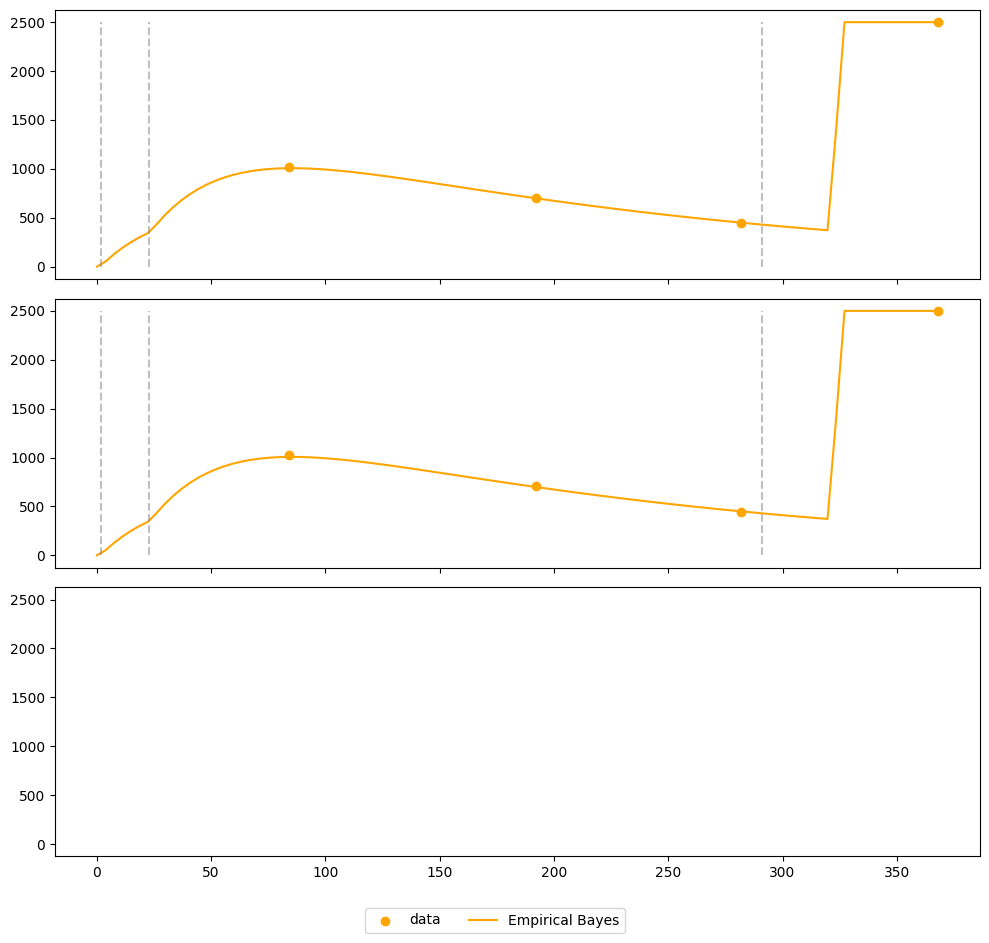

In [32]:
# chose random patients and plots
colors = ['orange', 'red']
with_noise = False
rows = 3
fig, ax = plt.subplots(rows, int(np.ceil(result.shape[0] / rows)), sharex='all', sharey='all',
                       tight_layout=True, figsize=(10, rows*3))
axis = ax.flatten()

for ax_i, p_id in tqdm(enumerate(range(result.shape[0])), total=result.shape[0]):
    if 'fröhlich' in model_name:
        partial_batch_simulator = partial(batch_simulator, 
                                          with_noise=with_noise)  
        # only one simulation, so format should be (#imulations)
        y = obs_data[p_id].flatten()
        t_measurements = np.linspace(1/6, 30, 180)
        t_measurements_last = t_measurements[-1]
        t_measurements_full = t_measurements
    elif 'clairon' in model_name or 'pharma' in model_name:
        partial_batch_simulator = partial(simulate_single_patient, 
                                          full_trajectory=True,
                                          patient_data=obs_data[individual_idx], 
                                          with_noise=with_noise)
        observations = convert_bf_to_observables(obs_data[individual_idx])
        # this is the same for the clairon and pharma model
        y = observations[0]
        t_measurements = observations[1]
        t_measurements_last = t_measurements[-1]
        t_measurements_full = np.linspace(0, t_measurements_last, 100)
    else:
        raise NotImplemented
    
    sim_data_eb = partial_batch_simulator(result['x'][p_id])
    if sim_data_eb.ndim == 1:
        sim_data_eb = sim_data_eb[:, np.newaxis]
        y = y[:, np.newaxis]
    for i in range(sim_data_eb.shape[1]):
        eb_handle, = axis[ax_i].plot(t_measurements_full, sim_data_eb[:, i], color=colors[i], label='Empirical Bayes')
        data_handle = axis[ax_i].scatter(t_measurements, y[:, i], color=colors[i], label='data')
    
    if 'clairon' in model_name or 'pharma' in model_name:
        axis[ax_i].vlines(doses_time_points, 0, np.max(y), color='grey', linestyles='--', alpha=0.5)
        
fig.legend(handles=[data_handle, eb_handle], loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

In [ ]:
%%time
filename = f'empirical_bayes_results/empirical_bayes-{model_name}-{covariance_format}-n_data_{n_data}.pkl'
if individual_model.prior_type == 'uniform':
    filename = filename.replace('.pkl', '-uniform.pkl')
    
if not os.path.exists(filename):
    print('running optimization')
    empirical_bayes_res_full = []
    for i in tqdm(range(n_data)):
        empirical_bayes_res_full.append(get_empirical_bayes(i))
       
    with open(filename, 'wb') as f:
        pickle.dump(empirical_bayes_res_full, f)
     
else:
    with open(filename, 'rb') as f:
        empirical_bayes_res_full = pickle.load(f)

In [ ]:
%%time
filename_l = f'empirical_bayes_results/likelihoods-{model_name}-{covariance_format}-n_data_{n_data}.pkl'
if individual_model.prior_type == 'uniform':
    filename_l = filename_l.replace('.pkl', '-uniform.pkl')

if not os.path.exists(filename_l):
    print('running optimization')
    likelihoods_res_full = []
    for i in tqdm(range(n_data)):
        likelihoods_res_full.append(get_likelihoods(i))
       
    with open(filename_l, 'wb') as f:
        pickle.dump(likelihoods_res_full, f)
     
else:
    with open(filename_l, 'rb') as f:
        likelihoods_res_full = pickle.load(f)

In [ ]:
# reduce dataframes to get only the estimates
empirical_bayes_res = np.array([np.array([i for  i in entry['x']]) for entry in empirical_bayes_res_full])
likelihoods_res = np.array([np.array([i for  i in entry['x']]) for entry in likelihoods_res_full])

In [ ]:
monolix_file = f'empirical_bayes_results/monolix_empirical_bayes-{model_name}-{covariance_format}-n_data_{n_data}.pkl'
if os.path.exists(monolix_file):
    with open(monolix_file, 'rb') as f:
        monolix_res_full = pickle.load(f)
        monolix_res = np.array([entry['x'][0] for entry in monolix_res_full])
       
    # monolix returns the standard deviation, not the variance
    # error variance is 0.0198533 = 0 (fixed parameters)  
    pop_mean_monolix = np.array([-2.93353166411073, 6.31425341363383, 0.964473501759479, -13.7105711552498,
                         -4.47952481537895, np.log(0.00476513494336853), np.log(0.233158512113676)])
    pop_cov_monolix = np.diag(np.array([0.632526977232295, 2.72768175190726, 0.825820609367505, 
                                        4.23649341947715, 0.423019422206937, 
                                        np.sqrt(0.0198533), np.sqrt(0.0198533)])**2)
else:
    monolix_res = None

In [ ]:
print(np.array(individual_model.param_names)[free_indices])
random_vars = empirical_bayes_res[:, 0, free_indices] - pop_mean[free_indices]
if monolix_res is not None:
    random_vars_monolix = monolix_res[:, free_indices] - pop_mean_monolix[free_indices]
print(np.mean(random_vars, axis=0))
print(pop_cov[free_indices, :].diagonal())
print(np.cov(random_vars.T).diagonal())

In [ ]:
print(normaltest(random_vars, axis=0).pvalue >= 0.05) # null hypothesis (sample is normal) cannot be rejected

if monolix_res is not None:
    print(normaltest(random_vars_monolix, axis=0).pvalue >= 0.05) # null hypothesis (sample is normal) cannot be rejected

In [ ]:
n_samples = 50
with_noise = False
obs = []
pred_median = []
posterior_median = []
posterior_all_samples = []
pred_empirical_bayes = []
pred_likelihood = []
pred_map = []
pred_monolix = []
pred_pop = []

for i in tqdm(range(len(obs_data))):
    if 'fröhlich' in model_name:
        partial_batch_simulator = partial(batch_simulator, 
                                          with_noise=with_noise)  
        # only one simulation, so format should be (#imulations)
        y = obs_data[i].flatten()
    elif 'clairon' in model_name or 'pharma' in model_name:
        partial_batch_simulator = partial(simulate_single_patient, 
                                          patient_data=obs_data[i], 
                                          with_noise=with_noise)
        observations = convert_bf_to_observables(obs_data[i])
        # this is the same for the clairon and pharma model
        y = observations[0]
    else:
        raise NotImplemented
    
    obs.append(y)
    
    # compute individual posterior-median of simulations
    posterior_samples_i = individual_model.draw_posterior_samples(data=obs_data[i][np.newaxis, :],
                                                                  n_samples=n_samples)
    posterior_median_i = np.median(posterior_samples_i, axis=0)
    posterior_median.append(posterior_median_i)
    posterior_all_samples.append(posterior_samples_i)
    
    sim_data_i = partial_batch_simulator(posterior_samples_i)
    pred_median.append(np.median(sim_data_i, axis=0))
    
    # simulate with the best empirical bayes
    sim_data_eb = partial_batch_simulator(empirical_bayes_res[i, 0])
    pred_empirical_bayes.append(sim_data_eb)
    
    # simulate with likelihood estimate
    sim_data_l = partial_batch_simulator(likelihoods_res[i, 0])
    pred_likelihood.append(sim_data_l)
    
    # simulate with map
    sim_data_map = partial_batch_simulator(posterior_median_i)
    pred_map.append(sim_data_map)
    
    # simulate with monolix
    if monolix_res is not None:
        sim_data_monolix = partial_batch_simulator(monolix_res[i])
        pred_monolix.append(sim_data_monolix)
    
posterior_median = np.array(posterior_median)

In [ ]:
# chose random patients and plots
np.random.seed(42)
rand_p_ids = np.random.choice(range(len(obs_data)), size=15, replace=False)

colors = ['orange', 'red']
rows = 3
fig, ax = plt.subplots(rows, int(np.ceil(len(rand_p_ids) / rows)), sharex='all', sharey='all',
                       tight_layout=True, figsize=(10, rows*3))
axis = ax.flatten()

for ax_i, p_id in tqdm(enumerate(rand_p_ids), total=len(rand_p_ids)):
    if 'fröhlich' in model_name:
        partial_batch_simulator = partial(batch_simulator, 
                                          with_noise=with_noise)  
        # only one simulation, so format should be (#imulations)
        y = obs_data[p_id].flatten()
        t_measurements = np.linspace(1/6, 30, 180)
        t_measurements_last = t_measurements[-1]
        t_measurements_full = t_measurements
    elif 'clairon' in model_name or 'pharma' in model_name:
        partial_batch_simulator = partial(simulate_single_patient, 
                                          full_trajectory=True,
                                          patient_data=obs_data[p_id], 
                                          with_noise=with_noise)
        observations = convert_bf_to_observables(obs_data[p_id])
        # this is the same for the clairon and pharma model
        y = observations[0]
        t_measurements = observations[1]
        doses_time_points = observations[2]
        t_measurements_last = t_measurements[-1]
        t_measurements_full = np.linspace(0, t_measurements_last, 100)
    else:
        raise NotImplemented
    
    sim_data_eb = partial_batch_simulator(empirical_bayes_res[p_id, 0])
    if sim_data_eb.ndim == 1:
        sim_data_eb = sim_data_eb[:, np.newaxis]
        y = y[:, np.newaxis]
    for i in range(sim_data_eb.shape[1]):
        eb_handle, = axis[ax_i].plot(t_measurements_full, sim_data_eb[:, i], color=colors[i], label='Empirical Bayes')
        data_handle = axis[ax_i].scatter(t_measurements, y[:, i], color=colors[i], label='data')
    
    if 'clairon' in model_name or 'pharma' in model_name:
        axis[ax_i].vlines(doses_time_points, 0, np.max(y), color='grey', linestyles='--', alpha=0.5)
    
    # empirical bayes based on monolix
    if monolix_res is not None:
        sim_data_monolix = partial_batch_simulator(monolix_res[p_id])
        monolix_handle, = axis[ax_i].plot(t_measurements_full, sim_data_monolix, 'r', label='EB - Monolix')
    else: 
        monolix_handle = None
        
if monolix_handle is not None:
    fig.legend(handles=[data_handle, eb_handle, monolix_handle], loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=3)
else:
    fig.legend(handles=[data_handle, eb_handle], loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=3)
#plt.savefig(f'plots/comparison_fits_clairon.png')
plt.show()

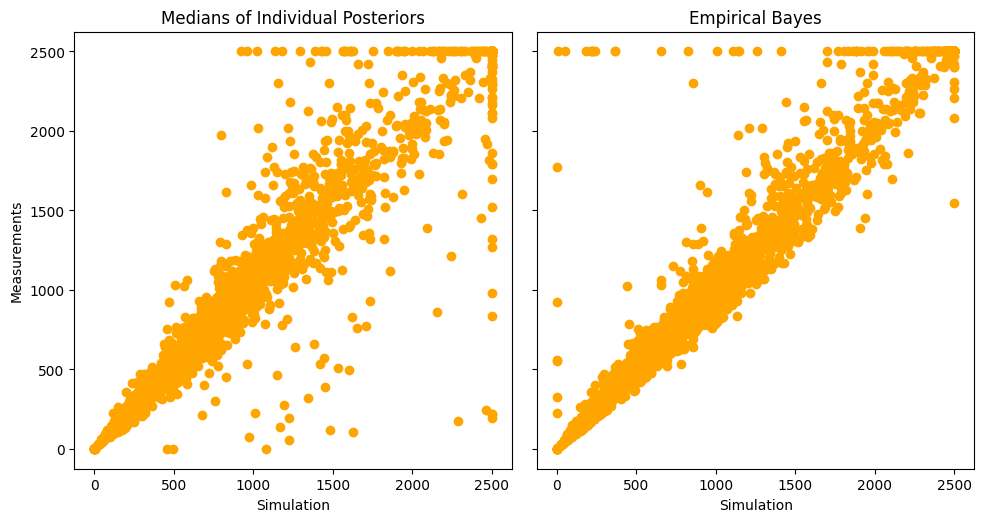

In [33]:
# plot individual fits
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey='all', sharex='all', tight_layout=True)
if obs[0].ndim == 2:
    obs_1 = np.concatenate([o[:, 0] for o in obs])
    obs_2 = np.concatenate([o[:, 1] for o in obs])
    pred_median_1 = np.concatenate([p[:, 0] for p in pred_median])
    pred_median_2 = np.concatenate([p[:, 1] for p in pred_median])
    pred_empirical_bayes_1 = np.concatenate([p[:, 0] for p in pred_empirical_bayes])
    pred_empirical_bayes_2 = np.concatenate([p[:, 1] for p in pred_empirical_bayes])
    ax[0].scatter(x=pred_median_1, y=obs_1, color=colors[0], label=f'Median of Individual Posterior')
    ax[1].scatter(x=pred_empirical_bayes_1, y=obs_1, color=colors[0], label=f'Empirical Bayes')
    ax[0].scatter(x=pred_median_2, y=obs_2, color=colors[1], label=f'Median of Individual Posterior')
    ax[1].scatter(x=pred_empirical_bayes_2, y=obs_2, color=colors[1], label=f'Empirical Bayes')
else:
    ax[0].scatter(x=pred_median, y=obs, color='orange', label=f'Median of Individual Posterior')
    ax[1].scatter(x=pred_empirical_bayes, y=obs, color='orange', label=f'Empirical Bayes')

ax[0].set_ylabel('Measurements')
ax[0].set_xlabel('Simulation')
ax[1].set_xlabel('Simulation')
ax[0].set_title('Medians of Individual Posteriors')
ax[1].set_title('Empirical Bayes')
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
#plt.savefig(f'plots/empirical_bayes_clairon{"_no" if obj_fun_amortized.covariance_format == "diag" else ""}_corr.png')
plt.show()

In [34]:
# compute shrinkage for every parameter (1 - variance of eta / variance of population), i.e. 1 is full shrinkage
shrinkage = []
shrinkage_posterior = []
shrinkage_monolix = []
var_random_effects = pop_cov.diagonal()
if monolix_res is not None:
    var_random_effects_monolix = pop_cov_monolix.diagonal()

for p_i in range(individual_model.n_params):
    # from empirical bayes
    eta_i = empirical_bayes_res[:, 0, p_i] - pop_mean[p_i]
    shrinkage_i = 1 - np.var(eta_i) / var_random_effects[p_i]
    shrinkage.append(shrinkage_i)
    
    # from posterior
    eta_pos_i = posterior_median[:, p_i] - pop_mean[p_i]
    shrinkage_i = 1 - np.var(eta_pos_i) / var_random_effects[p_i]
    shrinkage_posterior.append(shrinkage_i)
    
    # for monolix
    if monolix_res is not None:
        eta_monolix_i = monolix_res[:, p_i] - pop_mean_monolix[p_i]
        shrinkage_i = 1 - np.var(eta_monolix_i) / var_random_effects_monolix[p_i]
        shrinkage_monolix.append(shrinkage_i)

In [35]:
# compute correlation between random effects and covariates
if 'clairon' in model_name:
    correlation_age = []
    correlation_gender = []
    correlation_age_posterior = []
    correlation_gender_posterior = []
    for p_i in range(individual_model.n_params):
        # from empirical bayes
        eta_i = empirical_bayes_res[:, 0, p_i] - pop_mean[p_i]
        corr_i_age = np.corrcoef(eta_i, covariates[:, 0])[0, 1]
        corr_i_gender = np.corrcoef(eta_i, covariates[:, 1])[0, 1]
        correlation_age.append(corr_i_age)
        correlation_gender.append(corr_i_gender)
        
        # from posterior
        eta_pos_i = posterior_median[:, p_i] - pop_mean[p_i]
        corr_i_age = np.corrcoef(eta_pos_i, covariates[:, 0])[0, 1]
        corr_i_gender = np.corrcoef(eta_pos_i, covariates[:, 1])[0, 1]
        correlation_age_posterior.append(corr_i_age)
        correlation_gender_posterior.append(corr_i_gender)
        
    correlation = [correlation_age, correlation_gender]
    correlation_posterior = [correlation_age_posterior, correlation_gender_posterior]

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


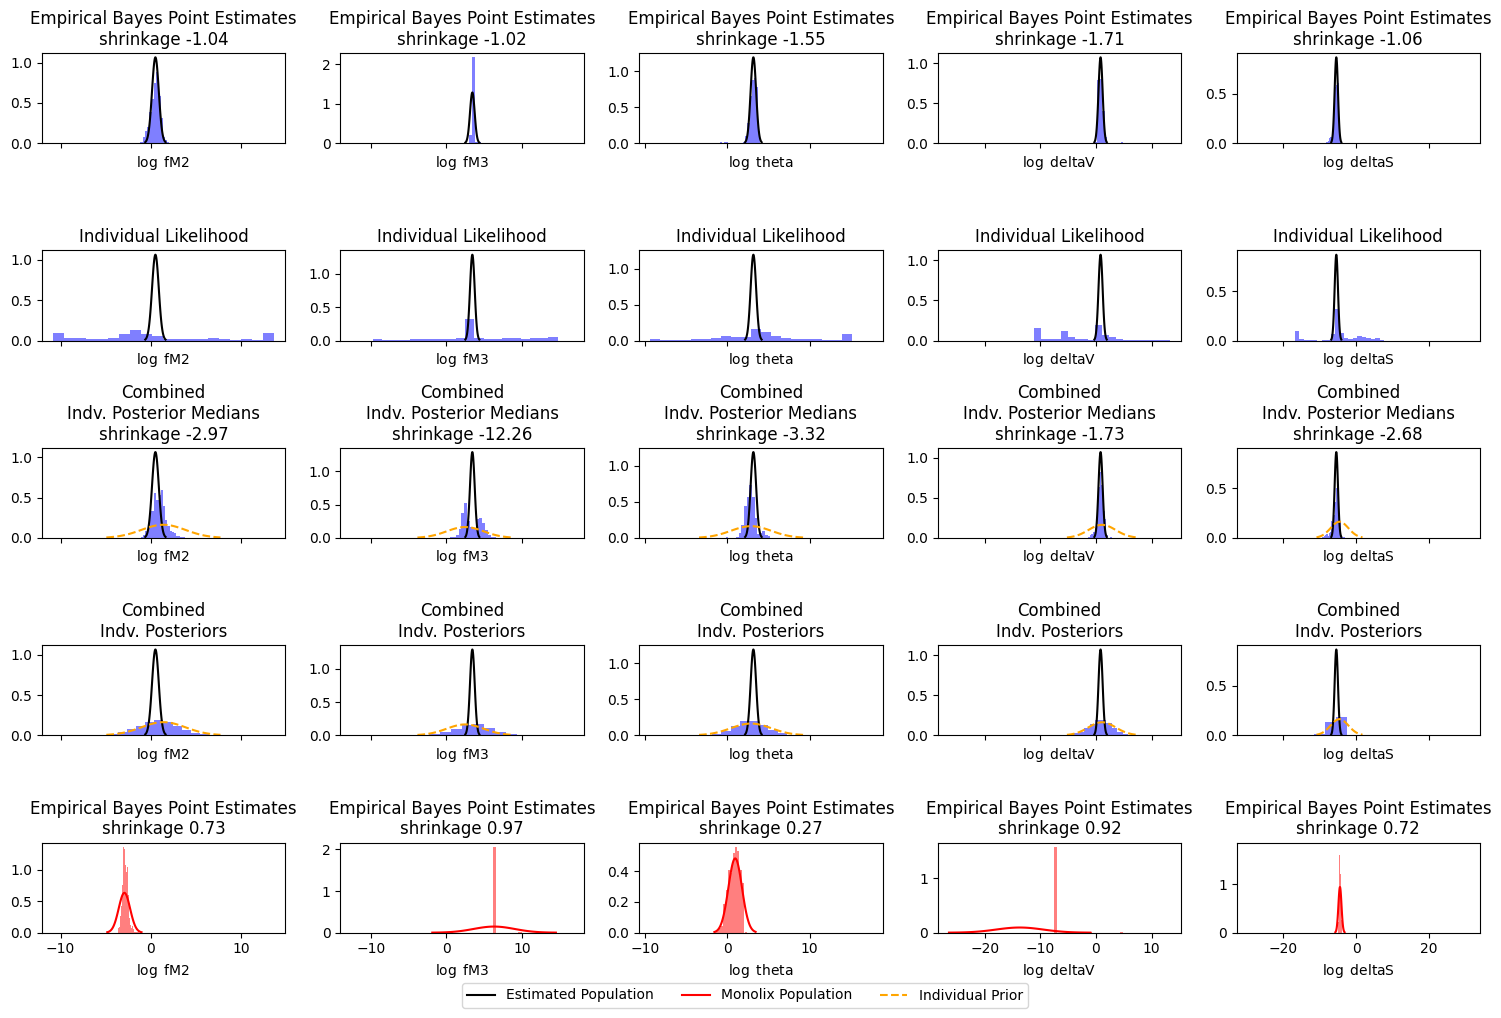

In [36]:
rows = 4 if monolix_res is None else 5
fig, ax = plt.subplots(rows, len(free_indices), figsize=(15,10), sharex='col',  #sharey='row', 
                       tight_layout=True)
ax_i = 0
for p_id in range(individual_model.n_params):
    if p_id not in free_indices:
        continue
    ax[0, ax_i].hist(empirical_bayes_res[:, 0, p_id], density=True, bins=20, color='blue', alpha=0.5)
    ax[0, ax_i].set_title(f'Empirical Bayes Point Estimates\nshrinkage {shrinkage[p_id]:.2f}')
    ax[0, ax_i].set_xlabel(individual_model.log_param_names[p_id])
    
    #ax[1, ax_i].hist(posterior_draws_eb[:, :, p_id].flatten(), weights=empirical_bayes_samples_weights.flatten(),
    #                 density=True, bins=20, color='blue', alpha=0.5)
    #ax[1, ax_i].set_title(f'Empirical Bayes Samples\nshrinkage {shrinkage_samples[p_id]:.2f}')
    #ax[1, ax_i].set_xlabel(individual_model.log_param_names[p_id])
    
    #ax[1, p_id].hist(empirical_bayes_res[:, :, p_id].flatten(), 
    #                 density=True, bins=20, color='blue', alpha=0.5)
    
    ax[1, ax_i].hist(likelihoods_res[:, 0, p_id], density=True, bins=20, color='blue', alpha=0.5)
    ax[1, ax_i].set_title(f'Individual Likelihood')
    ax[1, ax_i].set_xlabel(individual_model.log_param_names[p_id])
    
    ax[2, ax_i].hist(posterior_median[:, p_id], density=True, bins=20, color='blue', alpha=0.5)
    ax[2, ax_i].set_title(f'Combined\nIndv. Posterior Medians\nshrinkage {shrinkage_posterior[p_id]:.2f}')
    ax[2, ax_i].set_xlabel(individual_model.log_param_names[p_id])
    
    temp = np.concatenate([s[:, p_id] for s in posterior_all_samples])
    ax[3, ax_i].hist(temp, density=True, bins=20, color='blue', alpha=0.5)
    ax[3, ax_i].set_title(f'Combined\nIndv. Posteriors')
    ax[3, ax_i].set_xlabel(individual_model.log_param_names[p_id])

        
    # plot expected distribution
    x = np.linspace(pop_mean[p_id] - 3*np.sqrt(pop_cov.diagonal())[p_id], 
                    pop_mean[p_id] + 3*np.sqrt(pop_cov.diagonal())[p_id], 100)
    pop_density = stats.norm.pdf(x, pop_mean[p_id], np.sqrt(pop_cov.diagonal()[p_id]))
    for i in range(0, 4):
        pop_handle, = ax[i, ax_i].plot(x, pop_density,
                      color='black', label='Estimated Population')
    # plot pior
    if individual_model.prior_type == 'normal':
        x_prior = np.linspace(individual_model.prior_mean[p_id] - 2.58*individual_model.prior_std[p_id], 
                    individual_model.prior_mean[p_id] + 2.58*individual_model.prior_std[p_id], 100)
        prior_density = stats.norm.pdf(x_prior, individual_model.prior_mean[p_id], individual_model.prior_std[p_id])
        prior_handle, = ax[2, ax_i].plot(x_prior, prior_density, color='orange', label='Individual Prior', linestyle='--')
        prior_handle, = ax[3, ax_i].plot(x_prior, prior_density,
                                         color='orange', label='Individual Prior', linestyle='--')
    else:
        for i in range(0, ax.shape[0]):
            ax[i, ax_i].set_xlim(individual_model.prior_bounds[p_id])
    
    # monolix
    if monolix_res is not None:
        ax[4, ax_i].hist(monolix_res[:, p_id], density=True, bins=20, color='red', alpha=0.5)
        ax[4, ax_i].set_title(f'Empirical Bayes Point Estimates\nshrinkage {shrinkage_monolix[p_id]:.2f}')
        ax[4, ax_i].set_xlabel(individual_model.log_param_names[p_id])
    
        x = np.linspace(pop_mean_monolix[p_id] - 3*np.sqrt(pop_cov_monolix.diagonal())[p_id], 
                        pop_mean_monolix[p_id] + 3*np.sqrt(pop_cov_monolix.diagonal())[p_id], 100)
        pop_density_m = stats.norm.pdf(x, pop_mean_monolix[p_id], np.sqrt(pop_cov_monolix.diagonal()[p_id]))
        monolix_handle, = ax[4, ax_i].plot(x, pop_density_m, color='red', label='Monolix Population')
        
    ax_i += 1
    
# plot bounds for empirical bayes estimates
#ax0_ylim = ax[0, 0].get_ylim()
#ax1_ylim = ax[1, 0].get_ylim()
#ax5_ylim = ax[-1, 0].get_ylim()

#for p_id in range(individual_model.n_params):
    #bound_handle = ax[0, p_id].vlines(lower_bound[p_id], ax0_ylim[0], ax0_ylim[1], color='green', linestyle='--', label='Bounds')
    #ax[0, p_id].vlines(upper_bound[p_id], ax0_ylim[0], ax0_ylim[1], color='green', linestyle='--')
    #ax[1, p_id].vlines(lower_bound[p_id], ax1_ylim[0], ax1_ylim[1], color='green', linestyle='--')
    #ax[1, p_id].vlines(upper_bound[p_id], ax1_ylim[0], ax1_ylim[1], color='green', linestyle='--')

    

if monolix_res is not None:
    if individual_model.prior_type == 'uniform': 
        fig.legend(handles=[pop_handle, monolix_handle], 
                   loc='lower center', bbox_to_anchor=(0.5, -0.02), ncols=4)
    else:
        fig.legend(handles=[pop_handle, monolix_handle, prior_handle], 
                   loc='lower center', bbox_to_anchor=(0.5, -0.02), ncols=4)
else:
    if individual_model.prior_type == 'uniform': 
        fig.legend(handles=[pop_handle], 
                   loc='lower center', bbox_to_anchor=(0.5, -0.02), ncols=4)
    else:
        fig.legend(handles=[pop_handle, prior_handle], 
               loc='lower center', bbox_to_anchor=(0.5, -0.02), ncols=4)

#plt.savefig(f'plots/comparison_histograms_clairon.png')
plt.show()

In [ ]:
# plot covariates against individual parameters
covariate_names = ['age', 'gender']

col = 2 if monolix_res is None else 3

for covariate_i, c in enumerate(covariate_names):
    #y_axis_scale = lambda x: np.exp(x)
    y_axis_scale = lambda x: x
    
    fig, ax = plt.subplots(individual_model.n_params, col, figsize=(15,15), sharey='row', sharex='all', tight_layout=True)
    for p_id in range(individual_model.n_params):
        ax[p_id, 0].set_ylabel(individual_model.log_param_names[p_id])
        
        ax[p_id, 0].scatter(covariates[:, covariate_i], 
                            y_axis_scale(empirical_bayes_res[:, 0, p_id])-y_axis_scale(pop_mean[p_id]), 
                            color='orange')
        ax[p_id, 1].scatter(covariates[:, covariate_i], 
                            y_axis_scale(posterior_median[:, p_id])-y_axis_scale(pop_mean[p_id]), 
                            color='blue')
        if monolix_res is not None:
             ax[p_id, 2].scatter(covariates[:, covariate_i], 
                            y_axis_scale(monolix_res[:, p_id])-y_axis_scale(pop_mean[p_id]),
                                 #y_axis_scale(np.mean(monolix_res[:, p_id])),
                            color='red')
        # add text upper right corner
        ax[p_id, 0].text(0.7, 0.7, f'shrinkage {shrinkage[p_id]:.2f}\n'
                                     f'correlation {correlation[covariate_i][p_id]:.2f}',
                         transform=ax[p_id, 0].transAxes)
        ax[p_id, 1].text(0.7, 0.7, f'shrinkage {shrinkage_posterior[p_id]:.2f}\n'
                                        f'correlation {correlation_posterior[covariate_i][p_id]:.2f}',
                         transform=ax[p_id, 1].transAxes)
        if monolix_res is not None:
            ax[p_id, 2].text(0.7, 0.7, f'shrinkage {shrinkage_monolix[p_id]:.2f}',
                         transform=ax[p_id, 2].transAxes)
        # ax[p_id, 0].hlines(y_axis_scale(lower_bound[p_id])-y_axis_scale(pop_params[p_id]), 
        #                   np.min(covariates[:, covariate_i]), np.max(covariates[:, covariate_i]),
        #                   color='red', linestyles='--')
        # ax[p_id, 1].hlines(y_axis_scale(lower_bound[p_id])-y_axis_scale(pop_params[p_id]), 
        #                   np.min(covariates[:, covariate_i]), np.max(covariates[:, covariate_i]),
        #                   color='red', linestyles='--')
        # ax[p_id, 0].hlines(y_axis_scale(upper_bound[p_id])-y_axis_scale(pop_params[p_id]), 
        #                   np.min(covariates[:, covariate_i]), np.max(covariates[:, covariate_i]),
        #                   color='red', linestyles='--')
        # ax[p_id, 1].hlines(y_axis_scale(upper_bound[p_id])-y_axis_scale(pop_params[p_id]), 
        #                   np.min(covariates[:, covariate_i]), np.max(covariates[:, covariate_i]),
        #                   color='red', linestyles='--')
    
    ax[-1, 0].set_xlabel(f'{covariate_names[covariate_i]}')
    ax[-1, 1].set_xlabel(f'{covariate_names[covariate_i]}')
    ax[0, 0].set_title(f'Empirical Bayes')
    ax[0, 1].set_title(f'Individual Posterior Median\n(without population information)')
    if monolix_res is not None:
        ax[0, 2].set_title(f'Monolix Empirical Bayes')
        ax[-1, 2].set_xlabel(f'{covariate_names[covariate_i]}')
    
    #plt.savefig(f'plots/covariates_clairon{"_no" if obj_fun_amortized.covariance_format == "diag" else ""}_corr_{covariate_names[covariate_i]}.png')
    plt.show()

# Outlier detection

In [ ]:
# outlier detection
deviation = 2
outliers = np.zeros((len(obs_data), individual_model.n_params))
for p_id in range(individual_model.n_params):
    if p_id not in free_indices:
        continue
    
    # compute outlier detection
    # compute mean and std of empirical bayes estimates
    median_eb = np.median(empirical_bayes_res[:, 0, p_id])
    std_eb = np.std(empirical_bayes_res[:, 0, p_id])
    
    # 3 stds away from mean
    outliers[:, p_id] = np.abs(empirical_bayes_res[:, 0, p_id] - median_eb) > deviation*std_eb
    print(f'Outliers for {individual_model.log_param_names[p_id]}: {np.sum(outliers[:, p_id])}')
    
# get index of individuals which are outliers for at least one parameter
outlier_idx = np.arange(len(obs_data))[np.any(outliers, axis=1)]
print(f'Outliers for at least one parameter: {len(outlier_idx)}')

In [ ]:
colors = ['orange', 'red']
rows = 3
fig, ax = plt.subplots(rows, int(np.ceil(len(outlier_idx) / rows)), sharex='all', sharey='all',
                       tight_layout=True, figsize=(10, rows*3))
axis = ax.flatten()

for ax_i, p_id in tqdm(enumerate(outlier_idx)):
    axis[ax_i].set_title(f'Patient {p_id}')
    if 'fröhlich' in model_name:
        partial_batch_simulator = partial(batch_simulator, 
                                          with_noise=with_noise)  
        # only one simulation, so format should be (#imulations)
        y = obs_data[p_id].flatten()
        t_measurements = np.linspace(1/6, 30, 180)
        t_measurements_last = t_measurements[-1]
        t_measurements_full = t_measurements
    elif 'clairon' in model_name or 'pharma' in model_name:
        partial_batch_simulator = partial(simulate_single_patient, 
                                          full_trajectory=True,
                                          patient_data=obs_data[p_id], 
                                          with_noise=with_noise)
        observations = convert_bf_to_observables(obs_data[p_id])
        # this is the same for the clairon and pharma model
        y = observations[0]
        t_measurements = observations[1]
        doses_time_points = observations[2]
        t_measurements_last = t_measurements[-1]
        t_measurements_full = np.linspace(0, t_measurements_last, 100)
    else:
        raise NotImplemented
    
    sim_data_eb = partial_batch_simulator(empirical_bayes_res[p_id, 0])
    if sim_data_eb.ndim == 1:
        sim_data_eb = sim_data_eb[:, np.newaxis]
        y = y[:, np.newaxis]
    for i in range(sim_data_eb.shape[1]):
        eb_handle, = axis[ax_i].plot(t_measurements_full, sim_data_eb[:, i], color=colors[i], label='Empirical Bayes')
        data_handle = axis[ax_i].scatter(t_measurements, y[:, i], color=colors[i], label='data')
    
    if 'clairon' in model_name or 'pharma' in model_name:
        axis[ax_i].vlines(doses_time_points, 0, np.max(y), color='grey', linestyles='--', alpha=0.5)
    
    # empirical bayes based on monolix
    if monolix_res is not None:
        sim_data_monolix = partial_batch_simulator(monolix_res[p_id])
        monolix_handle, = axis[ax_i].plot(t_measurements_full, sim_data_monolix, 'r', label='EB - Monolix')
    else: 
        monolix_handle = None
        
if monolix_handle is not None:
    fig.legend(handles=[data_handle, eb_handle, monolix_handle], loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=3)
else:
    fig.legend(handles=[data_handle, eb_handle], loc='lower center',
               bbox_to_anchor=(0.5, -0.05), ncol=3)
#plt.savefig(f'plots/comparison_fits_clairon.png')
for _ax in fig.axes[len(outlier_idx):]:  
    _ax.remove()
plt.show()